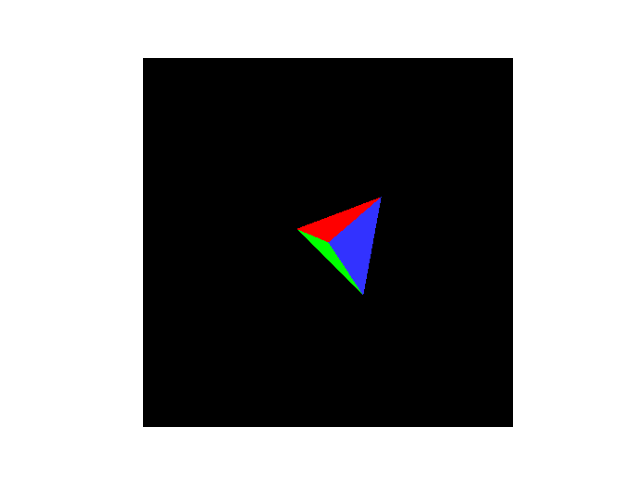

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from math import pi
%matplotlib widget

def pt_in_tri(p, p0, p1, p2):
    s = (p0[0] - p2[0]) * (p[1] - p2[1]) - (p0[1] - p2[1]) * (p[0] - p2[0]) #s, t, 1-s-t are barycentric coords
    t = (p1[0] - p0[0]) * (p[1] - p0[1]) - (p1[1] - p0[1]) * (p[0] - p0[0])

    if ((s < 0) != (t < 0) and s != 0 and t != 0):
        return False

    d = (p2[0] - p1[0]) * (p[1] - p1[1]) - (p2[1] - p1[1]) * (p[0] - p1[0])
    return d == 0 or (d < 0) == (s + t <= 0)
    
def pt_in_tri2(p, p0, p1, p2):
    dX = p[0]-p2[0];
    dY = p[1]-p2[1];
    dX21 = p2[0]-p1[0];
    dY12 = p1[1]-p2[1];
    D = dY12*(p0[0]-p2[0]) + dX21*(p0[1]-p2[1]);
    s = dY12*dX + dX21*dY;
    t = (p2[1]-p0[1])*dX + (p0[0]-p2[0])*dY;
    if (D<0):
        return s<=0 and t<=0 and s+t>=D
    return s>=0 and t>=0 and s+t<=D;

def draw_tetra(ax, offset, scale, zdist, roll, pitch, yaw):

    # triangle vertices
    vertices = np.matrix([
        [0, 0, 0], #tetrahedron
        [0, 0, 1], 
        [0, 1, 0], 
        [1, 0, 0]
    ])

    # indices for each face, then the rgb color
    faces = np.array([
        [[0, 1, 2], [255, 0, 0]],  # red
        [[0, 1, 3], [0, 255, 0]],  # green 
        [[0, 2, 3], [50, 50, 255]],  #light blue
        [[1, 2, 3], [255, 255, 0]]  #yellow
    ])

    roll_mat = np.matrix([
        [1, 0, 0], 
        [0, np.cos(roll), -np.sin(roll)], 
        [0, np.sin(roll), np.cos(roll)]
    ])
    pitch_mat = np.matrix([
        [np.cos(pitch), 0, np.sin(pitch)], 
        [0, 1, 0], 
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    yaw_mat = np.matrix([
        [np.cos(yaw), -np.sin(yaw), 0], 
        [np.sin(yaw), np.cos(yaw), 0], 
        [0, 0, 1]
    ])

    vertices = np.array((roll_mat@pitch_mat@yaw_mat@(vertices.T)).T)
    # print(vertices[0,0])

    # print(vertices)
    # Screen parameters
    width, height = 400, 400
    screen = np.zeros((height, width, 3), dtype=np.uint8)  # RGB image buffer

    def draw_line(p1, p2):
        """Draw a line between two points on the screen."""
        x1, y1 = p1
        x2, y2 = p2
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        if(dx == 0 and dy==0):
            return
        if dx > dy:
            steps = dx
        else:
            steps = dy
        x_increment = (x2 - x1) / steps
        y_increment = (y2 - y1) / steps
        # print("steps", steps)
        x, y = x1, y1
        for _ in range(int(steps)-1):
            try:
                screen[int(x)][int(y)] = [255, 255, 255]  # White color
            except:
                # print('out')
                pass
            x += x_increment
            y += y_increment



    # loop through each 3D face, generate list of 2D triangles 
    tri_list = []
    for face_index in range(len(faces)):
        face_v_indexes = faces[face_index][0]

        v = np.zeros((3, 3))
        for i in range(3):
            v[i] = vertices[face_v_indexes[i]] #each is 3d vector

        # Convert vertices to screen space
        v_screen = np.zeros((3, 2))
        for i in range(3):
            v_screen[i][0] = (v[i][0]) * scale / (v[i][2] + zdist) + offset # x screen coord
            v_screen[i][1] = (v[i][1]) * scale / (v[i][2] + zdist) + offset # y screen coord

        z_sum = v[0][2] + v[1][2] + v[2][2]

        # draw_line(v_screen[0], v_screen[1])
        # draw_line(v_screen[1], v_screen[2])
        # draw_line(v_screen[2], v_screen[0])
        # rgb = faces[face_index][1]
        # screen[int(np.average(v_screen[:,0]))][int(np.average(v_screen[:,1]))] = [rgb[0], rgb[1], rgb[2]]

        # if(face_index == 1):
        # print([int(np.average(v_screen[:,0])), int(np.average(v_screen[:,1]))], rgb)
        
        tri_list.append((v_screen[0], v_screen[1], v_screen[2], z_sum))


    # for tri in tri_list:
    #     print("trilist", tri)

    for x in range(0, width):
        for y in range(0, height):
            p = (x,y)
            min_z = 1e9
            for tri_index in range(len(tri_list)):
                tri = tri_list[tri_index]
                rgb = faces[tri_index][1]
                if(pt_in_tri2(p, tri[0], tri[1], tri[2])):
                    if(tri[3] < min_z):
                        # if(p==(214, 201)):
                        #     print(tri)
                            # print(p, tri[0], tri[1], tri[2])
                        min_z = tri[3]
                        screen[x][y] = rgb

    # Display the rendered image
    ax.imshow(screen)
    ax.axis('off')
    # plt.show()

fig, ax = plt.subplots(1, 1)
draw_tetra(ax, 200, 800, 10, 0.5, -0.2, 0.7)

interactive(children=(FloatSlider(value=200.0, description='offset', max=400.0, step=1.0), FloatSlider(value=8…

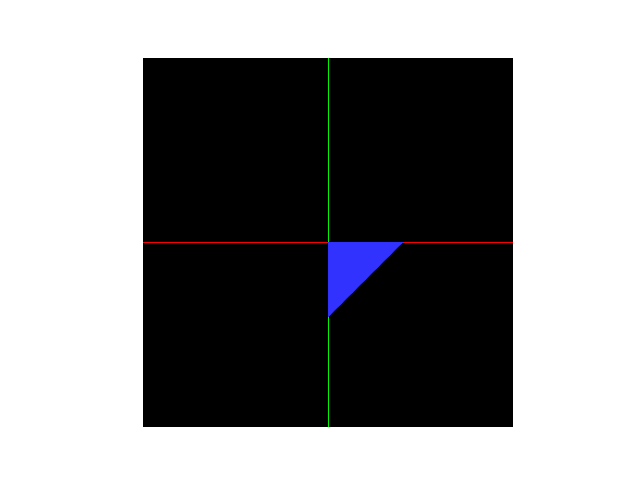

In [57]:
plt.close('all')
fig, ax = plt.subplots(1, 1)
@interact(
    offset=FloatSlider(min=0, max=400, step=1, value=200),
    scale=FloatSlider(min=0, max=1000, step=1, value=800),
    zdist=FloatSlider(min=2, max=50, step=1, value=10),

    roll=FloatSlider(min=0, max=2*pi, step=0.1, value=0),
    pitch=FloatSlider(min=0, max=2*pi, step=0.1, value=0),
    yaw=FloatSlider(min=0, max=2*pi, step=0.1, value=0)
)
def display_image(offset, scale, zdist, roll, pitch, yaw):
    ax.clear()
    draw_tetra(ax, offset, scale, zdist, roll, pitch, yaw)
    

plt.show()